---
title: "permutation test"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

We wish to compare two samples, and see if they significantly differ regarding some statistic of interest (median, mean, etc.). To make things concrete, let's talk about the heights of 12-year-old boys and girls. Are girls significantly taller than boys?

## hypotheses

* **Null hypothesis (H0):** The two samples come from the same distribution.
* **Alternative hypothesis (H1):** Girls are taller than boys.

The basic idea behind the permutation test is that, *if the null hypothesis is correct*, then it wouldn't matter if we relabelled the samples. If we randomly permute the labels "girls" and "boys" of the two samples, the statistic of interest should not change significantly. However, if by permuting the labels we get a significantly different statistic, then we can reject the null hypothesis.

That's beautiful, right?

## steps

1. Compute the statistic of interest (e.g., the difference in medians) for the original samples.
1. Randomly permute the labels of the two samples.
1. Compute the statistic of interest for the permuted samples.
1. Repeat steps 2 and 3 many times (e.g., 1000 times) to create a distribution of the statistic under the null hypothesis.
1. Compare the original statistic to the distribution of permuted statistics to see if it is significantly different (e.g., by checking if it falls in the top 5% of the distribution). From this, we can numerically compute a p-value.

## example

Let's use the very same example as in the [independent samples t-test](/t_test/t_test_independent_samples.html).

In [26]:
#| code-summary: "import libraries"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)
from scipy.stats import norm, ttest_ind, t
# %matplotlib widget

In [27]:
#| code-summary: "load data"
df_boys = pd.read_csv('../archive/data/height/boys_height_stats.csv', index_col=0)
df_girls = pd.read_csv('../archive/data/height/girls_height_stats.csv', index_col=0)
age = 12.0
mu_boys = df_boys.loc[age, 'mu']
mu_girls = df_girls.loc[age, 'mu']
sigma_boys = df_boys.loc[age, 'sigma']
sigma_girls = df_girls.loc[age, 'sigma']

In [28]:
#| code-summary: "generate data"
N_boys = 10
N_girls = 14
# set scipy seed for reproducibility
np.random.seed(314)
sample_boys = norm.rvs(size=N_boys, loc=mu_boys, scale=sigma_boys)
sample_girls = norm.rvs(size=N_girls, loc=mu_girls, scale=sigma_girls)

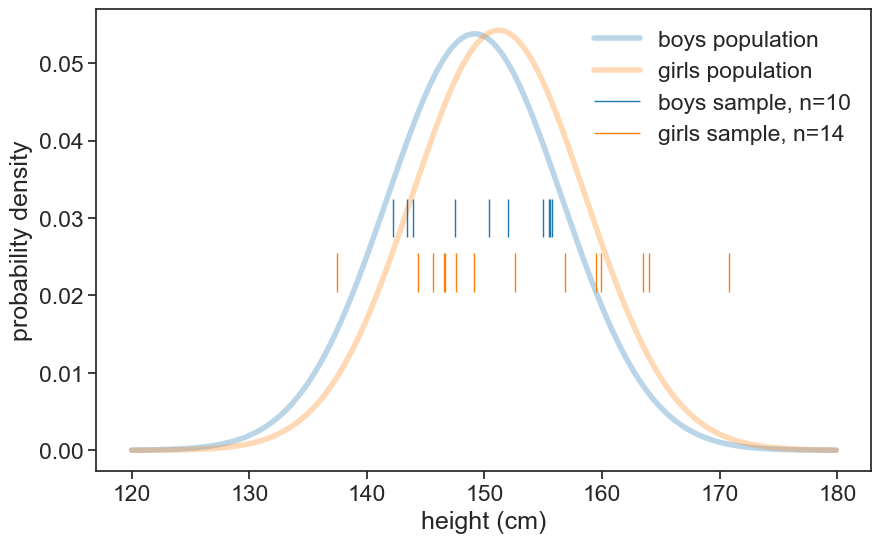

In [29]:
#| code-summary: "plot population and sample data"
height_list = np.arange(120, 180, 0.1)
pdf_boys = norm.pdf(height_list, loc=mu_boys, scale=sigma_boys)
pdf_girls = norm.pdf(height_list, loc=mu_girls, scale=sigma_girls)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(height_list, pdf_boys, lw=4, alpha=0.3, color='tab:blue', label='boys population')
ax.plot(height_list, pdf_girls, lw=4, alpha=0.3, color='tab:orange', label='girls population')

ax.eventplot(sample_boys, orientation="horizontal", lineoffsets=0.03,
             linewidth=1, linelengths= 0.005,
             colors='tab:blue', label=f'boys sample, n={N_boys}')
ax.eventplot(sample_girls, orientation="horizontal", lineoffsets=0.023,
             linewidth=1, linelengths= 0.005,
             colors='tab:orange', label=f'girls sample, n={N_girls}')
ax.legend(frameon=False)
ax.set(xlabel='height (cm)',
       ylabel='probability density',
    );

The statistic of interest now is the difference in medians between the two samples.

In [30]:
#| code-summary: "compute the observed difference in medians"

# define the desired statistic.
# in can be anything you want, you can even write your own function.
statistic = np.median
# compute the median for each sample and the difference
median_girls = statistic(sample_girls)
median_boys = statistic(sample_boys)
observed_diff = median_girls - median_boys
print(f"median height for girls: {median_girls:.2f} cm")
print(f"median height for boys: {median_boys:.2f} cm")
print(f"median difference (girls minus boys): {observed_diff:.2f} cm")

median height for girls: 150.88 cm
median height for boys: 151.19 cm
median difference (girls minus boys): -0.31 cm


In [ ]:
#| code-summary: "permutation algorithm"
#| code-fold: false

N_permutations = 1000
# combine all values in one array
all_data = np.concatenate([sample_girls, sample_boys])
# create an array to store the differences
diffs = np.empty(N_permutations-1)

for i in range(N_permutations - 1):    # this "minus 1" will be explained later
    # permute the labels
    permuted = np.random.permutation(all_data)
    new_girls = permuted[:N_girls]  # first 14 values are girls
    new_boys = permuted[N_girls:]   # remaining values are boys
    diffs[i] = statistic(new_girls) - statistic(new_boys)
# add the observed difference to the array of differences
diffs = np.append(diffs, observed_diff)

Now let's see the empirical cdf of the permuted statistics, and where the original statistic falls in that distribution.

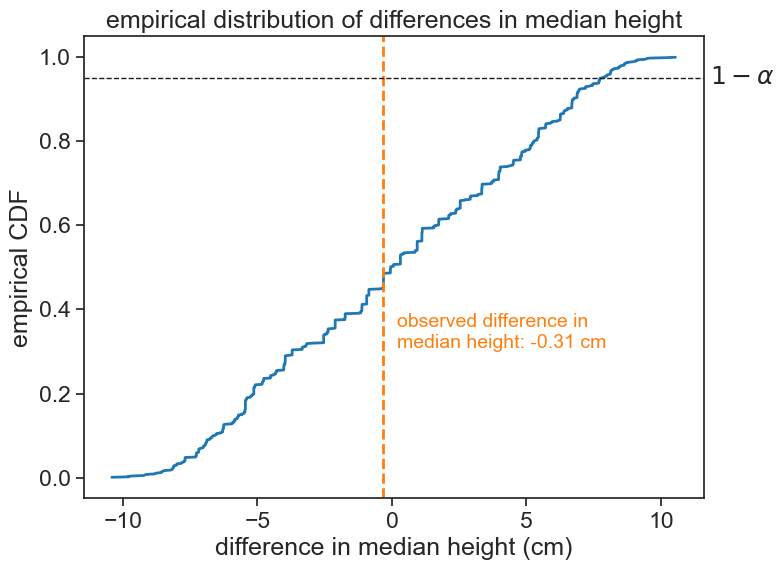

In [32]:
#| code-summary: "plot empirical distribution of differences"
fig, ax = plt.subplots(figsize=(8, 6))

# compute the empirical CDF
rank = np.arange(len(diffs)) + 1
cdf = rank / (len(diffs) + 1)
sorted_diffs = np.sort(diffs)

ax.plot(sorted_diffs, cdf, lw=2, color='tab:blue', label='empirical CDF')
ax.axvline(observed_diff, color='tab:orange', lw=2, ls='--',
           label=f'obs. median diff. = {observed_diff:.2f} cm')
ax.text(observed_diff + 0.5, 0.3, f'observed difference in\nmedian height: {observed_diff:.2f} cm',
        color='tab:orange', fontsize=14, ha='left', va='bottom')

alpha = 0.05
# for a one-tailed test
ax.axhline(1-alpha, color='k', lw=1, ls='--')
ax.annotate(r"$1-\alpha$", xy=(1.01, 1-alpha), xycoords=('axes fraction', 'data'),
            ha="left", va="center")
# for a two-tailed test
# ax.axhline(alpha/2, color='k', lw=1, ls='--')
# ax.axhline(1-alpha/2, color='k', lw=1, ls='--')
# ax.annotate(r"$\alpha/2$", xy=(1.01, alpha/2), xycoords=('axes fraction', 'data'),
#             ha="left", va="center")
# ax.annotate(r"$1-\alpha/2$", xy=(1.01, 1-alpha/2), xycoords=('axes fraction', 'data'),
#             ha="left", va="center")
ax.set(xlabel='difference in median height (cm)',
         ylabel='empirical CDF',
         title=f'empirical distribution of differences in median height');

The observed statistic is well within the boundaries set by the significance level of 5%. Therefore, we cannot reject the null hypothesis. We conclude that, based on this data, the most probable interpretation is that girls and boys have the same underlying distribution.

## increase sample size

Let's increase the sample size to 200 girls and 300 boys.

In [33]:
#| code-summary: "the whole process in one cell"
# take samples
N_boys = 300
N_girls = 200
# set scipy seed for reproducibility
np.random.seed(314)
sample_boys = norm.rvs(size=N_boys, loc=mu_boys, scale=sigma_boys)
sample_girls = norm.rvs(size=N_girls, loc=mu_girls, scale=sigma_girls)

# compute the observed difference in medians
statistic = np.median
# compute the median for each sample and the difference
median_girls = statistic(sample_girls)
median_boys = statistic(sample_boys)
observed_diff = median_girls - median_boys

# permutation algorithm
N_permutations = 1000
# combine all values in one array
all_data = np.concatenate([sample_girls, sample_boys])
# create an array to store the differences
diffs = np.empty(N_permutations-1)
for i in range(N_permutations - 1):    # this "minus 1" will be explained later
    # permute the labels
    permuted = np.random.permutation(all_data)
    new_girls = permuted[:N_girls]  # first 200 values are girls
    new_boys = permuted[N_girls:]   # remaining values are boys
    diffs[i] = statistic(new_girls) - statistic(new_boys)
# add the observed difference to the array of differences
diffs = np.append(diffs, observed_diff)

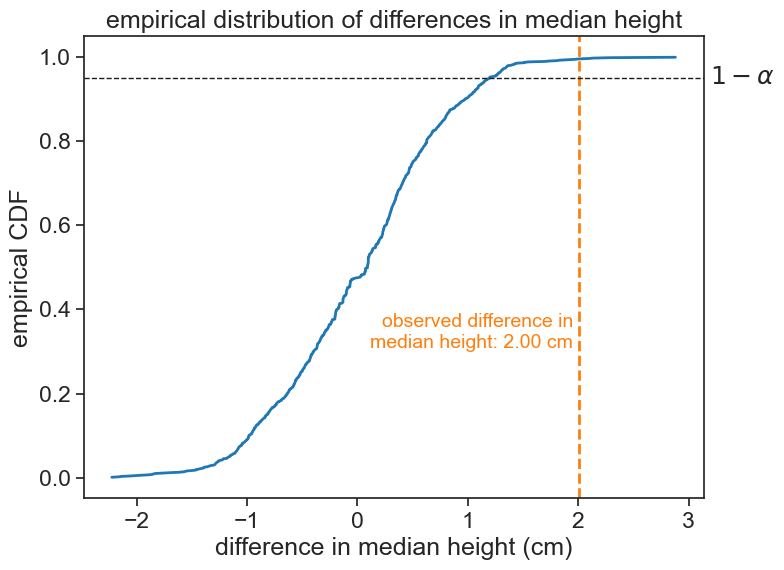

In [34]:
#| code-summary: "plot empirical distribution of differences"
fig, ax = plt.subplots(figsize=(8, 6))

# compute the empirical CDF
rank = np.arange(len(diffs)) + 1
cdf = rank / (len(diffs) + 1)
sorted_diffs = np.sort(diffs)

ax.plot(sorted_diffs, cdf, lw=2, color='tab:blue', label='empirical CDF')
ax.axvline(observed_diff, color='tab:orange', lw=2, ls='--',
           label=f'obs. median diff. = {observed_diff:.2f} cm')
ax.text(observed_diff - 0.05, 0.3, f'observed difference in\nmedian height: {observed_diff:.2f} cm',
        color='tab:orange', fontsize=14, ha='right', va='bottom')

alpha = 0.05
# for a one-tailed test
ax.axhline(1-alpha, color='k', lw=1, ls='--')
ax.annotate(r"$1-\alpha$", xy=(1.01, 1-alpha), xycoords=('axes fraction', 'data'),
            ha="left", va="center")
# for a two-tailed test
# ax.axhline(alpha/2, color='k', lw=1, ls='--')
# ax.axhline(1-alpha/2, color='k', lw=1, ls='--')
# ax.annotate(r"$\alpha/2$", xy=(1.01, alpha/2), xycoords=('axes fraction', 'data'),
#             ha="left", va="center")
# ax.annotate(r"$1-\alpha/2$", xy=(1.01, 1-alpha/2), xycoords=('axes fraction', 'data'),
#             ha="left", va="center")

ax.set(xlabel='difference in median height (cm)',
         ylabel='empirical CDF',
         title=f'empirical distribution of differences in median height');

Now the observed statistic is well outside the right boundary set by the significance level of 5%. Therefore, we can reject the null hypothesis. We conclude that, based on this data, girls are significantly taller than boys.

## p-value



It is quite easy to compute the p-value from the permutation test. It is simply the fraction of permuted statistics that are more extreme than the observed statistic. In this case, since we are testing whether girls are taller than boys, we have a one-tailed test, and we only consider the right tail of the distribution. If we were testing whether girls are significantly different from boys in their height, we would have a two-tailed test, and we would consider both tails of the distribution.

In [35]:
#| code-summary: "compute p-value"
#| code-fold: false

# one-tailed p-value
p_value = np.mean(diffs >= observed_diff)
# two-tailed p-value
# p_value = np.mean(np.abs(diffs) >= np.abs(observed_diff))
print(f"observed difference: {observed_diff:.3f}")
print(f"p-value (one-tailed): {p_value:.4f}")

observed difference: 2.004
p-value (one-tailed): 0.0050


We can now address the fact that we ran only 999 permutations, although I intended to run 1000. See in the code that after the permutation algorithm, I inserted the original statistic in the list of permuted statistics. This is because I want to compute the p-value as the fraction of permuted statistics that are more extreme than the original statistic, and I want to include the original statistic in the distribution. If I had not done this, for a truly extreme observed statistic, we would get that the p-value equals 0, that is, the fraction of permuted statistics that are more extreme than the observed statistic is zero. To avoid this behavior, we include the original statistic in the distribution of permuted statistics.

A corollary of this is that the smallest p-value we can get is 0.001 (for our example with 1000 permutations).